<a href="https://colab.research.google.com/github/gayecolakoglu/Malaria_Detection_Deep_Learning/blob/main/Bayesian_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pathlib
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

In [ ]:
#https://medium.com/@pierre.beaujuge/bayesian-optimization-on-the-head-classifier-of-pre-trained-cnns-using-the-cifar10-dataset-48c440b67b2c
# Install GPy, GPyOpt
!pip install tensorflow-addons
!pip install GPy==1.9.8
!pip install GPyOpt==1.2.1
import tensorflow as tf
import tensorflow.keras as K
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline
import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization
import tensorflow_addons as tfa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.5/989.5 KB 25.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 KB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for GPy: filename=GPy-1.9.8-cp38-cp38-linux_x86_64.whl size=3525786 sha256=c139be6c0060b86bfabbc4c6fa6dda5545dc1c23d39389a1fa7fdffea451eba5
  Stored in directory: /root/.cache/pip/wheels/75/7c/1b/efc2b7349d76a79624df08d8e1c35eb33198b70f651a9d6ffd
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102566 sha256=93b3af5c304e7eadfdaeb1c9cd4680c781cdada07384f14bb74fc61bc01bbc0c
  Stored in directory: /root/.cache/pip/wheels/66/78/6c/d98cb43783

In [ ]:
data_dir = "/content/gdrive/MyDrive/Colab Notebooks/ML/content/CLAHE/"
data_dir = pathlib.Path(data_dir)

parasited_count = len(list(data_dir.glob('Parasitized/*.png')))
print("Parasited:",parasited_count)

uninfected_count = len(list(data_dir.glob('Uninfected/*.png')))
print("Uninfected:",uninfected_count)

Parasited: 13779
Uninfected: 13779


In [ ]:
data_dir = "/content/gdrive/MyDrive/Colab Notebooks/ML/cell_images/"
data_dir = pathlib.Path(data_dir)

parasited_count = len(list(data_dir.glob('Parasitized/*.png')))
print("Parasited:",parasited_count)

uninfected_count = len(list(data_dir.glob('Uninfected/*.png')))
print("Uninfected:",uninfected_count)

Parasited: 13779
Uninfected: 13779


In [ ]:
!pip install split-folders
import splitfolders
splitfolders.ratio('/content/gdrive/MyDrive/Colab Notebooks/ML/content/CLAHE//', output="output", seed=1337, ratio=(.7, 0.2, 0.1)) #train,val,test

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 27558 files [01:21, 336.38 files/s]


In [ ]:
data_dir = "/content/output/"
data_dir = pathlib.Path(data_dir)

parasited_count = len(list(data_dir.glob('train/Parasitized/*.png')))
print("train/Parasited:",parasited_count)

uninfected_count = len(list(data_dir.glob('train/Uninfected/*.png')))
print("train/Uninfected:",uninfected_count)

parasited_count = len(list(data_dir.glob('test/Parasitized/*.png')))
print("test/Parasited:",parasited_count)

uninfected_count = len(list(data_dir.glob('test/Uninfected/*.png')))
print("test/Uninfected:",uninfected_count)

parasited_count = len(list(data_dir.glob('val/Parasitized/*.png')))
print("val/Parasited:",parasited_count)

uninfected_count = len(list(data_dir.glob('val/Uninfected/*.png')))
print("val/Uninfected:",uninfected_count)

train/Parasited: 9645
train/Uninfected: 9645
test/Parasited: 1379
test/Uninfected: 1379
val/Parasited: 2755
val/Uninfected: 2755


In [ ]:
#https://stackoverflow.com/questions/55674648/how-to-load-local-dataset-x-y-using-keras-framework
!pip install image-dataset-loader
from image_dataset_loader import load

(x_train, y_train), (x_test, y_test) = load('/content/output/', ['train', 'val']) # Görselleri dataframe'e yazar target'la birlikte. Görselleri array olarak tutar.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Görselleri normalize eder (x = x / 255) targetlara da one hot encoding yapar (1,0,0)
def preprocess_data(X, Y):
    """
    function that pre-processes the DR dataset as per
    densenet model requirements for input images
    labels are one-hot encoded
    """
    X = tf.keras.applications.vgg16.preprocess_input(X)
    Y = K.utils.to_categorical(Y)
    return X, Y

In [ ]:
# preprocess the data using the application's preprocess_input method and convert the labels to one-hot encodings
x_train, y_train = preprocess_data(x_train, y_train)
x_test, y_test = preprocess_data(x_test, y_test)

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dense,Flatten,Conv2D,Activation,Dropout

input_tensor = K.Input(shape=(32, 32, 3)) # Input olarak girecek yapıyı oluşturur
# resize images to the image size upon which the network was pre-trained
resized_images = K.layers.Lambda(lambda image: tf.image.resize(image, (224, 224)))(input_tensor) # lambda list comp. gibi input_tensordaki tüm image'ı resize ediyor
base_model = VGG16(include_top=False,
                    weights='imagenet',
                    input_tensor=resized_images,
                    input_shape=(224, 224, 3),
                    pooling='max',
                    classes=2)

output = base_model.layers[-1].output
base_model = K.models.Model(inputs=input_tensor, outputs=output)

In [ ]:
base_model.summary()

In [ ]:
# using the training data
train_datagen = K.preprocessing.image.ImageDataGenerator( #augmentation for train set
                horizontal_flip=True,
                vertical_flip=True,
                rescale=1./255,
                shear_range=0.2,
                zoom_range=0.2
                )

train_generator = train_datagen.flow(x_train,
                                     y_train,
                                     batch_size=32,
                                     shuffle=False)
features_train = base_model.predict(train_generator)
# repeat the same operation with the test data (here used for validation)
val_datagen = K.preprocessing.image.ImageDataGenerator()  # no augmentation for validation set
val_generator = val_datagen.flow(x_test,
                                 y_test,
                                 batch_size=32,
                                 shuffle=False)
features_valid = base_model.predict(val_generator)

In [ ]:
'''
from keras import backend

def recall_m(y_true, y_pred):
    true_positives = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = backend.sum(backend.round(backend.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + backend.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = backend.sum(backend.round(backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + backend.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+backend.epsilon()))
'''

'\nfrom keras import backend\n\ndef recall_m(y_true, y_pred):\n    true_positives = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)))\n    possible_positives = backend.sum(backend.round(backend.clip(y_true, 0, 1)))\n    recall = true_positives / (possible_positives + backend.epsilon())\n    return recall\n\ndef precision_m(y_true, y_pred):\n    true_positives = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)))\n    predicted_positives = backend.sum(backend.round(backend.clip(y_pred, 0, 1)))\n    precision = true_positives / (predicted_positives + backend.epsilon())\n    return precision\n\ndef f1_m(y_true, y_pred):\n    precision = precision_m(y_true, y_pred)\n    recall = recall_m(y_true, y_pred)\n    return 2*((precision*recall)/(precision+recall+backend.epsilon()))\n'

In [ ]:
from tensorflow.keras import layers, models
from keras.models import Sequential, Model

def build_model(units=256, learning_rate=1e-4, l2=1e-2, activation=2, rate=0.5, batch = 32, optim=1):
  """function that builds a model for the head classifier"""
  # weights are initialized as per the he et al. method
  initializer = K.initializers.he_normal()
  input_tensor = K.Input(shape=features_train.shape[1])
  activation_dict = {1: 'relu', 2: 'elu', 3: 'tanh'}
  optimizer_dict = {1: 'Adam', 2: 'SGD', 3: 'RMSprop'}
  layer = K.layers.Dense(units=units,
                         activation=activation_dict[activation],
                         kernel_initializer=initializer,
                        kernel_regularizer=K.regularizers.l2(l2=l2))
  output = layer(input_tensor)
  dropout = K.layers.Dropout(rate)
  output = dropout(output)
  softmax = K.layers.Dense(units=2,
                           activation='softmax',
                           kernel_initializer=initializer,
                        kernel_regularizer=K.regularizers.l2(l2=l2))
  output = softmax(output)
  model = K.models.Model(inputs=input_tensor, outputs=output)
  # compile the densely-connected head classifier (here, "model")
  if optim==1:
    model.compile(
            optimizer=K.optimizers.Adam(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=["accuracy"])
  elif optim==2:
    model.compile(
            optimizer=K.optimizers.SGD(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=["accuracy"])
  elif optim==3:
    model.compile(
            optimizer=K.optimizers.RMSprop(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=["accuracy"])
  else:
    print("Wrong optimizer!!")
  # Define some callback functions to be used by the model during training
  # reduce learning rate when val_accuracy has stopped improving
  lr_reduce = K.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                            factor=0.6,
                                            patience=2,
                                            verbose=1,
                                            mode='max',
                                            min_lr=1e-7)
  # stop training when val_accuracy has stopped improving
  early_stop = K.callbacks.EarlyStopping(monitor='val_accuracy',
                                         patience=3,
                                         verbose=1,
                                         mode='max')
  # callback to save the Keras model and (best) weights obtained on an epoch basis
  checkpoint = K.callbacks.ModelCheckpoint('VGG_16.h5',
                                           monitor='val_accuracy',
                                           verbose=1,
                                           save_weights_only=False,
                                           save_best_only=True,
                                           mode='max',
                                           save_freq='epoch')
  return model, lr_reduce, early_stop, checkpoint, batch

In [ ]:
def fit_model(model, lr_reduce, early_stop, checkpoint, batch):
  """function that trains the head classifier"""
  history = model.fit(features_train, y_train,
                      batch_size=batch,
                      epochs=100,
                      verbose=0,
                      callbacks=[lr_reduce, early_stop, checkpoint],
                      validation_data=(features_valid, y_test),
                      shuffle=True)
  return history

In [ ]:
def evaluate_model(model):
  """function that evaluates the head classifier"""
  evaluation = model.evaluate(features_valid, y_test)
  return evaluation


Hyperparameters: [[1.28e+02 1.00e-04 1.00e-03 3.00e+00 7.00e-01 1.28e+02 1.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.51456, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.51456 to 0.59223, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.59223 to 0.64401, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.64401 to 0.68285, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.68285 to 0.73139, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.73139 to 0.74434, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.74434 to 0.76052, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.76052 to 0.78317, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.78317 to 0.79288, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.79288 to 0.79935, saving model to VGG_16.h5

Epoch 11: val_accuracy did not improve from 0.79935

Epoch 12: val_accuracy improved f

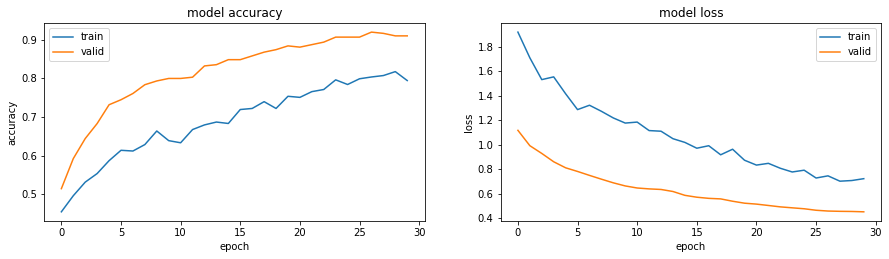


Hyperparameters: [[2.56e+02 1.00e-03 1.00e-03 1.00e+00 3.00e-01 3.20e+01 2.00e+00]]
10/10 [==============================] - 0s 3ms/step - loss: 0.4528 - accuracy: 0.9094

Epoch 1: val_accuracy improved from -inf to 0.92557, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.92557

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.92557

Epoch 4: val_accuracy improved from 0.92557 to 0.94175, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.94175

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 6: val_accuracy did not improve from 0.94175

Epoch 7: val_accuracy did not improve from 0.94175
Epoch 7: early stopping
10/10 [==============================] - 0s 3ms/step - loss: 1.0641 - accuracy: 0.9353

LOSS:	1.0640811920166016 	 ACCURACY:	0.9352750778198242
[1.0640811920166016, 0.9352750778198242]



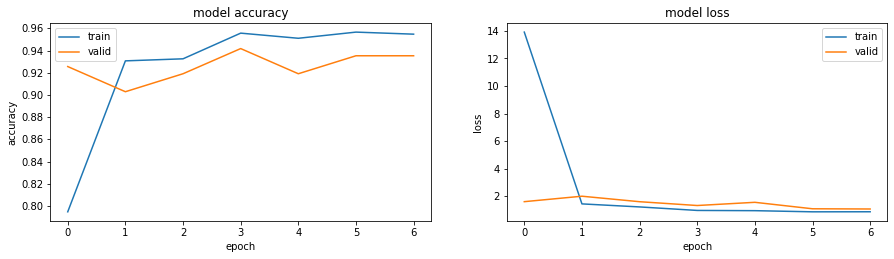


Hyperparameters: [[2.56e+02 1.00e-03 1.00e-03 2.00e+00 5.00e-01 1.28e+02 1.00e+00]]
10/10 [==============================] - 0s 3ms/step - loss: 1.0641 - accuracy: 0.9353

Epoch 1: val_accuracy improved from -inf to 0.73463, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.73463 to 0.90291, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.90291 to 0.92880, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.92880 to 0.93528, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.93528 to 0.94822, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.94822 to 0.95146, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.95146 to 0.95793, saving model to VGG_16.h5

Epoch 8: val_accuracy did not improve from 0.95793

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 9: val_accuracy did not improve from 0.95793

Epoch 10: val_accuracy did not improve from 0.95793
Epoch 10: early 

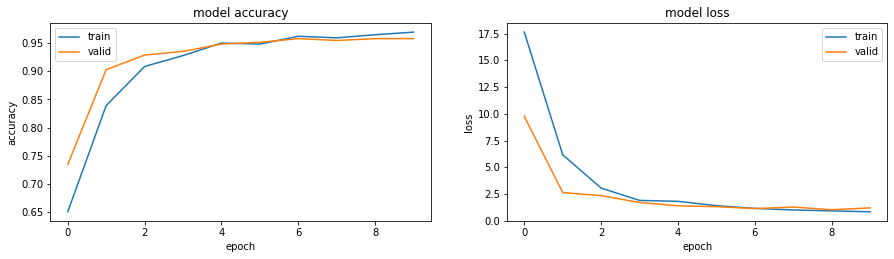


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-01 1.00e+00 7.00e-01 1.28e+02 2.00e+00]]
10/10 [==============================] - 0s 3ms/step - loss: 1.1961 - accuracy: 0.9579

Epoch 1: val_accuracy improved from -inf to 0.56958, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.56958 to 0.93204, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.93204

Epoch 4: val_accuracy improved from 0.93204 to 0.94175, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.94175

Epoch 6: val_accuracy improved from 0.94175 to 0.94822, saving model to VGG_16.h5

Epoch 7: val_accuracy did not improve from 0.94822

Epoch 8: val_accuracy improved from 0.94822 to 0.95146, saving model to VGG_16.h5

Epoch 9: val_accuracy did not improve from 0.95146

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 10: val_accuracy did not improve from 0.95146

Epoch 11: val_accuracy did not improve from 0.95146
Epoch 11: early stopping

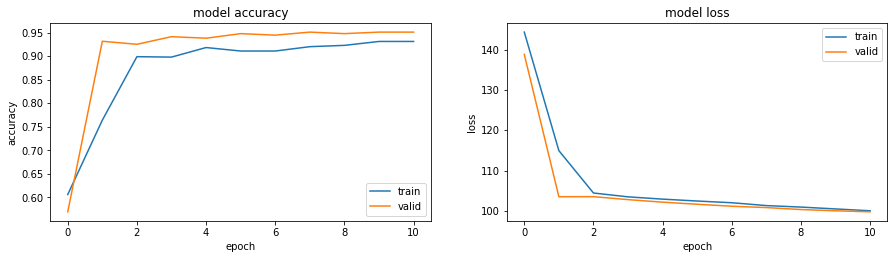


Hyperparameters: [[6.4e+01 1.0e-04 1.0e-01 2.0e+00 3.0e-01 3.2e+01 3.0e+00]]
10/10 [==============================] - 0s 3ms/step - loss: 1.1961 - accuracy: 0.9579

Epoch 1: val_accuracy improved from -inf to 0.87702, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.87702 to 0.90291, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.90291 to 0.91586, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.91586 to 0.93204, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.93204

Epoch 6: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 6: val_accuracy did not improve from 0.93204

Epoch 7: val_accuracy improved from 0.93204 to 0.93528, saving model to VGG_16.h5

Epoch 8: val_accuracy did not improve from 0.93528

Epoch 9: ReduceLROnPlateau reducing learning rate to 3.599999909056351e-05.

Epoch 9: val_accuracy did not improve from 0.93528

Epoch 10: val_accuracy did not improve from 0.93528
Epoch 10

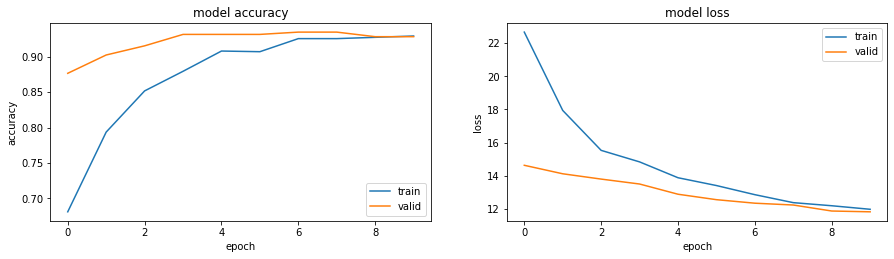




Hyperparameters: [[5.12e+02 1.00e-05 1.00e-01 3.00e+00 5.00e-01 3.20e+01 3.00e+00]]
10/10 [==============================] - 0s 3ms/step - loss: 1.1961 - accuracy: 0.9579

Epoch 1: val_accuracy improved from -inf to 0.46278, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.46278 to 0.47573, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.47573 to 0.49515, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.49515 to 0.51780, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.51780 to 0.54369, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.54369 to 0.57282, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.57282 to 0.60194, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.60194 to 0.61489, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.61489 to 0.64078, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.64078 to 0.65372, saving model to VGG_16.h

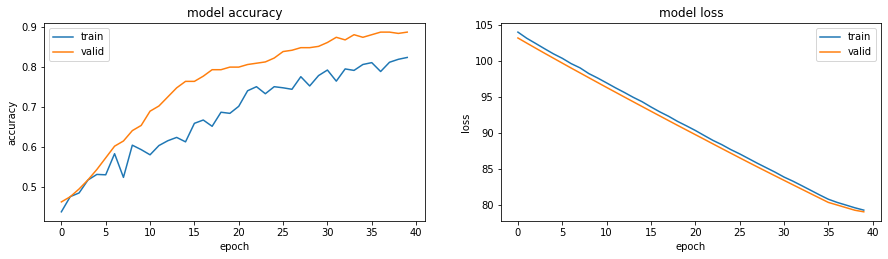


Hyperparameters: [[2.56e+02 1.00e-04 1.00e-03 1.00e+00 3.00e-01 1.28e+02 1.00e+00]]
10/10 [==============================] - 0s 3ms/step - loss: 1.1961 - accuracy: 0.9579

Epoch 1: val_accuracy improved from -inf to 0.60518, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.60518 to 0.75728, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.75728 to 0.86408, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.86408 to 0.88350, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.88350 to 0.92233, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.92233 to 0.93528, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.93528 to 0.94175, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.94175 to 0.94822, saving model to VGG_16.h5

Epoch 9: val_accuracy did not improve from 0.94822

Epoch 10: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 10: val_accuracy did not impro

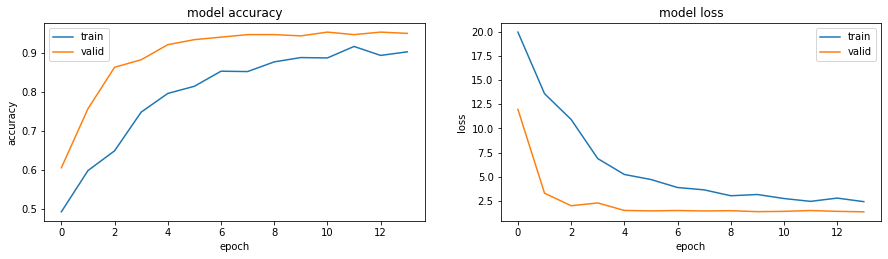


Hyperparameters: [[2.56e+02 1.00e-04 1.00e-03 2.00e+00 5.00e-01 3.20e+01 2.00e+00]]
10/10 [==============================] - 0s 3ms/step - loss: 1.1961 - accuracy: 0.9579

Epoch 1: val_accuracy improved from -inf to 0.85113, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.85113 to 0.86731, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.86731 to 0.90291, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.90291 to 0.91262, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.91262 to 0.91909, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.91909 to 0.92557, saving model to VGG_16.h5

Epoch 7: val_accuracy did not improve from 0.92557

Epoch 8: val_accuracy improved from 0.92557 to 0.93528, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.93528 to 0.93851, saving model to VGG_16.h5

Epoch 10: val_accuracy did not improve from 0.93851

Epoch 11: ReduceLROnPlateau reducing learning rate to 5.99999

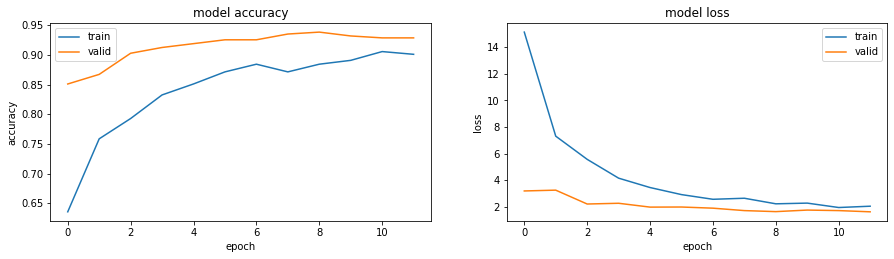


Hyperparameters: [[2.56e+02 1.00e-06 1.00e-02 1.00e+00 5.00e-01 1.28e+02 3.00e+00]]
10/10 [==============================] - 0s 3ms/step - loss: 1.1961 - accuracy: 0.9579

Epoch 1: val_accuracy improved from -inf to 0.54369, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.54369

Epoch 3: val_accuracy improved from 0.54369 to 0.55016, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.55016 to 0.57282, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.57282 to 0.58900, saving model to VGG_16.h5

Epoch 6: val_accuracy did not improve from 0.58900

Epoch 7: val_accuracy improved from 0.58900 to 0.59547, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.59547 to 0.60518, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.60518 to 0.61165, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.61165 to 0.62460, saving model to VGG_16.h5

Epoch 11: val_accuracy improved from 0.62460 to 0.62783, savi

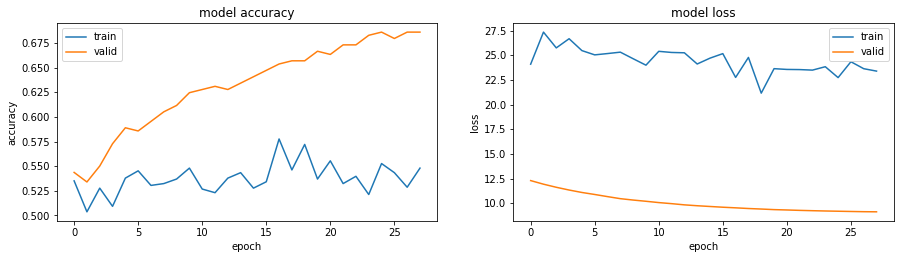


Hyperparameters: [[6.40e+01 1.00e-03 1.00e-03 2.00e+00 3.00e-01 1.28e+02 3.00e+00]]
10/10 [==============================] - 0s 3ms/step - loss: 1.1961 - accuracy: 0.9579

Epoch 1: val_accuracy improved from -inf to 0.87055, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.87055 to 0.90291, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.90291 to 0.91586, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.91586 to 0.93851, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.93851 to 0.94822, saving model to VGG_16.h5

Epoch 6: val_accuracy did not improve from 0.94822

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 7: val_accuracy did not improve from 0.94822

Epoch 8: val_accuracy improved from 0.94822 to 0.95469, saving model to VGG_16.h5

Epoch 9: val_accuracy did not improve from 0.95469

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 10: val_accurac

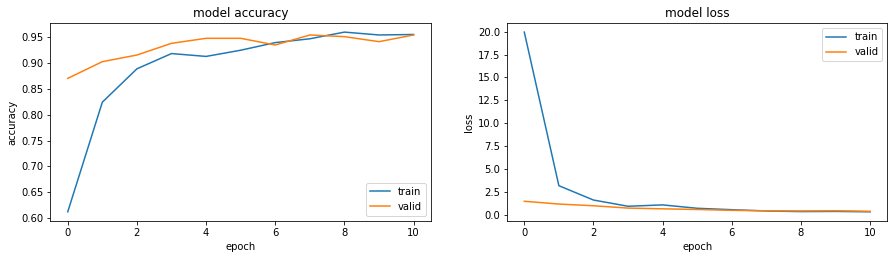


Hyperparameters: [[6.4e+01 1.0e-04 1.0e-01 2.0e+00 3.0e-01 3.2e+01 1.0e+00]]
10/10 [==============================] - 0s 3ms/step - loss: 1.1961 - accuracy: 0.9579

Epoch 1: val_accuracy improved from -inf to 0.61165, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.61165 to 0.82524, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.82524 to 0.87379, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.87379 to 0.90615, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.90615 to 0.91909, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.91909 to 0.92233, saving model to VGG_16.h5

Epoch 7: val_accuracy did not improve from 0.92233

Epoch 8: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 8: val_accuracy did not improve from 0.92233

Epoch 9: val_accuracy improved from 0.92233 to 0.92557, saving model to VGG_16.h5

Epoch 10: val_accuracy did not improve from 0.92557

Epoch 11: val_accuracy

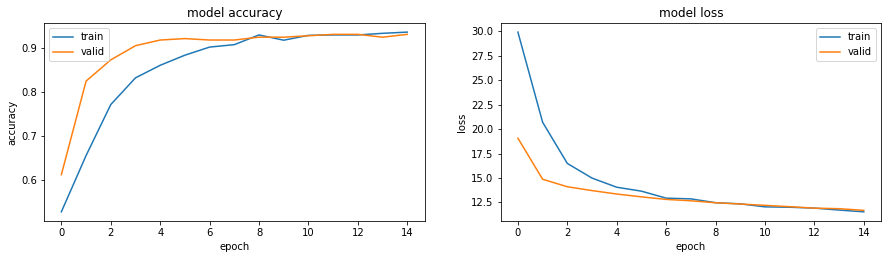


Hyperparameters: [[6.4e+01 1.0e-04 1.0e-02 3.0e+00 3.0e-01 3.2e+01 3.0e+00]]
10/10 [==============================] - 0s 3ms/step - loss: 1.1961 - accuracy: 0.9579

Epoch 1: val_accuracy improved from -inf to 0.61489, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.61489 to 0.66667, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.66667 to 0.76052, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.76052 to 0.77670, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.77670 to 0.81230, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.81230 to 0.82201, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.82201 to 0.85437, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.85437 to 0.86084, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.86084 to 0.86408, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.86408 to 0.88026, saving model to VGG_16.h5

Epoch 

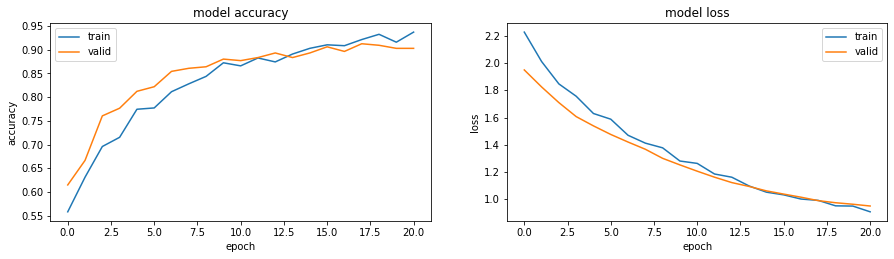


Hyperparameters: [[6.40e+01 1.00e-04 1.00e-01 2.00e+00 5.00e-01 1.28e+02 2.00e+00]]
10/10 [==============================] - 0s 3ms/step - loss: 1.1961 - accuracy: 0.9579

Epoch 1: val_accuracy improved from -inf to 0.57605, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.57605 to 0.63430, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.63430 to 0.73139, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.73139 to 0.76375, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.76375 to 0.78964, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.78964 to 0.79288, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.79288 to 0.80906, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.80906 to 0.84142, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.84142 to 0.84790, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.84790 to 0.85437, saving model to VGG_16.h5


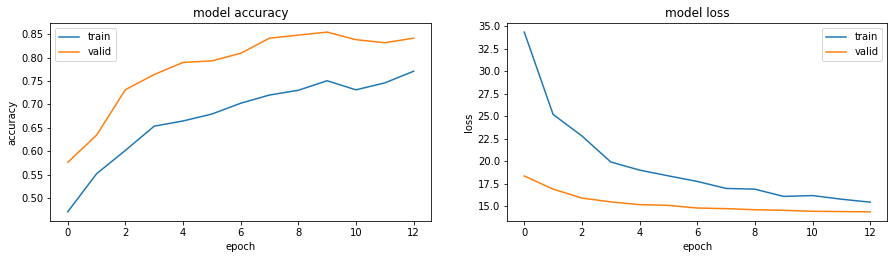


Hyperparameters: [[1.28e+02 1.00e-06 1.00e-01 1.00e+00 7.00e-01 2.56e+02 2.00e+00]]
10/10 [==============================] - 0s 3ms/step - loss: 1.1961 - accuracy: 0.9579

Epoch 1: val_accuracy improved from -inf to 0.29773, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.29773 to 0.31068, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.31068 to 0.31392, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.31392

Epoch 5: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 5: val_accuracy did not improve from 0.31392

Epoch 6: val_accuracy did not improve from 0.31392
Epoch 6: early stopping
10/10 [==============================] - 0s 4ms/step - loss: 43.2456 - accuracy: 0.3139

LOSS:	43.245574951171875 	 ACCURACY:	0.31391584873199463
[43.245574951171875, 0.31391584873199463]



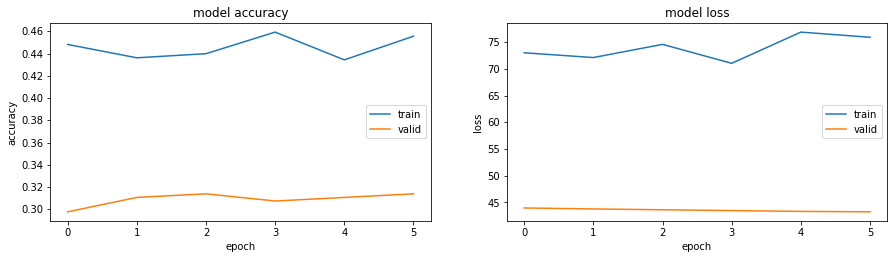


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-02 1.00e+00 5.00e-01 1.28e+02 2.00e+00]]
10/10 [==============================] - 0s 4ms/step - loss: 1.1961 - accuracy: 0.9579

Epoch 1: val_accuracy improved from -inf to 0.70227, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.70227 to 0.90615, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.90615 to 0.92880, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.92880

Epoch 5: val_accuracy improved from 0.92880 to 0.93851, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.93851 to 0.94822, saving model to VGG_16.h5

Epoch 7: val_accuracy did not improve from 0.94822

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 8: val_accuracy did not improve from 0.94822

Epoch 9: val_accuracy did not improve from 0.94822
Epoch 9: early stopping
10/10 [==============================] - 0s 3ms/step - loss: 10.9439 - accuracy: 0.9482

LOSS:	10.943888664

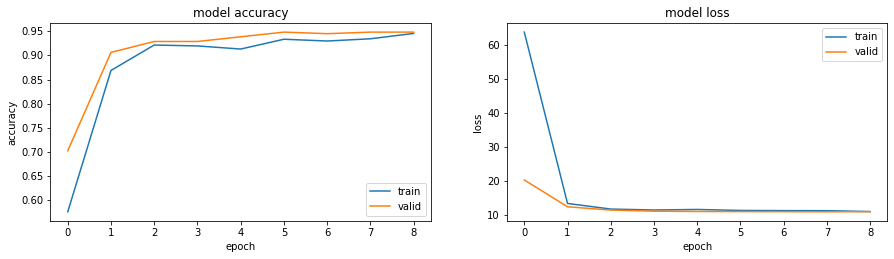


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-02 1.00e+00 3.00e-01 2.56e+02 3.00e+00]]
10/10 [==============================] - 0s 4ms/step - loss: 1.1961 - accuracy: 0.9579

Epoch 1: val_accuracy improved from -inf to 0.64725, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.64725 to 0.65372, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.65372

Epoch 4: val_accuracy improved from 0.65372 to 0.65696, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.65696

Epoch 6: val_accuracy improved from 0.65696 to 0.66343, saving model to VGG_16.h5

Epoch 7: val_accuracy did not improve from 0.66343

Epoch 8: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 8: val_accuracy did not improve from 0.66343

Epoch 9: val_accuracy did not improve from 0.66343
Epoch 9: early stopping
10/10 [==============================] - 0s 3ms/step - loss: 16.1104 - accuracy: 0.6602

LOSS:	16.110448837280273 	 ACCURACY:	0.6601941585

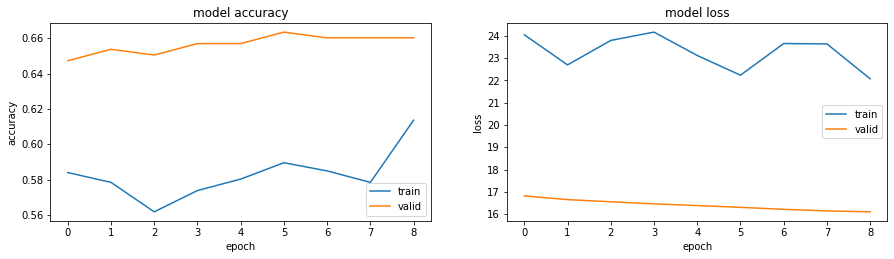


Hyperparameters: [[6.40e+01 1.00e-03 1.00e-02 1.00e+00 7.00e-01 2.56e+02 2.00e+00]]
10/10 [==============================] - 0s 3ms/step - loss: 1.1961 - accuracy: 0.9579

Epoch 1: val_accuracy improved from -inf to 0.82201, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.82201 to 0.83172, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.83172 to 0.83819, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.83819

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 5: val_accuracy did not improve from 0.83819

Epoch 6: val_accuracy improved from 0.83819 to 0.84466, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.84466 to 0.84790, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.84790 to 0.85761, saving model to VGG_16.h5

Epoch 9: val_accuracy did not improve from 0.85761

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 10: val_accurac

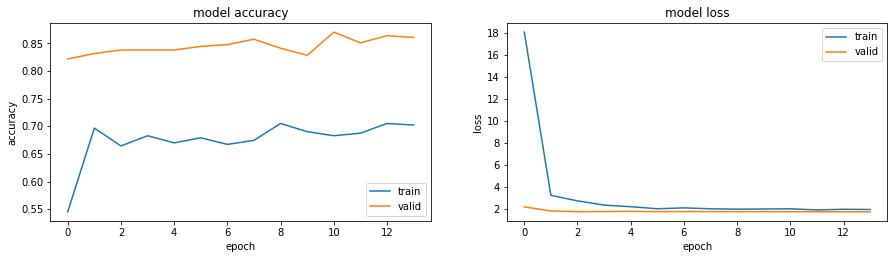


Hyperparameters: [[6.40e+01 1.00e-06 1.00e-03 1.00e+00 7.00e-01 2.56e+02 2.00e+00]]
10/10 [==============================] - 1s 13ms/step - loss: 1.1961 - accuracy: 0.9579

Epoch 1: val_accuracy improved from -inf to 0.48220, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.48220 to 0.48544, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.48544 to 0.49191, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.49191 to 0.49838, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.49838

Epoch 6: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 6: val_accuracy did not improve from 0.49838

Epoch 7: val_accuracy improved from 0.49838 to 0.50809, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.50809 to 0.51133, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.51133 to 0.51456, saving model to VGG_16.h5

Epoch 10: val_accuracy did not improve from 0.51456

Epoch 11: val_

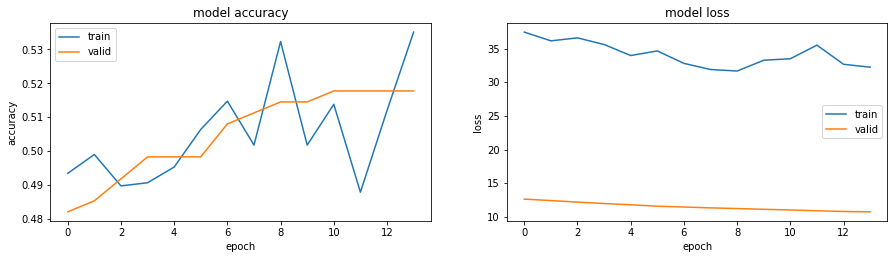


Hyperparameters: [[2.56e+02 1.00e-06 1.00e-02 2.00e+00 7.00e-01 2.56e+02 1.00e+00]]
10/10 [==============================] - 0s 3ms/step - loss: 1.1961 - accuracy: 0.9579

Epoch 1: val_accuracy improved from -inf to 0.44337, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.44337

Epoch 3: val_accuracy improved from 0.44337 to 0.44660, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.44660

Epoch 5: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 5: val_accuracy did not improve from 0.44660

Epoch 6: val_accuracy did not improve from 0.44660
Epoch 6: early stopping
10/10 [==============================] - 0s 4ms/step - loss: 26.7200 - accuracy: 0.4466

LOSS:	26.720035552978516 	 ACCURACY:	0.446601927280426
[26.720035552978516, 0.446601927280426]



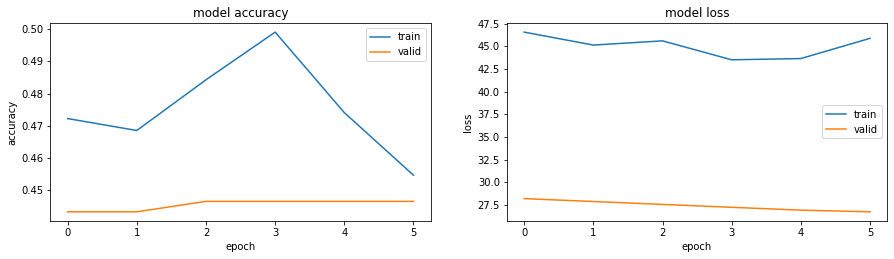


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-01 1.00e+00 3.00e-01 3.20e+01 2.00e+00]]
10/10 [==============================] - 0s 3ms/step - loss: 1.1961 - accuracy: 0.9579

Epoch 1: val_accuracy improved from -inf to 0.62460, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.62460 to 0.68608, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.68608 to 0.71521, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.71521 to 0.75081, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.75081 to 0.78317, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.78317 to 0.80583, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.80583 to 0.81553, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.81553 to 0.84142, saving model to VGG_16.h5

Epoch 9: val_accuracy did not improve from 0.84142

Epoch 10: val_accuracy improved from 0.84142 to 0.85437, saving model to VGG_16.h5

Epoch 11: val_accuracy improve

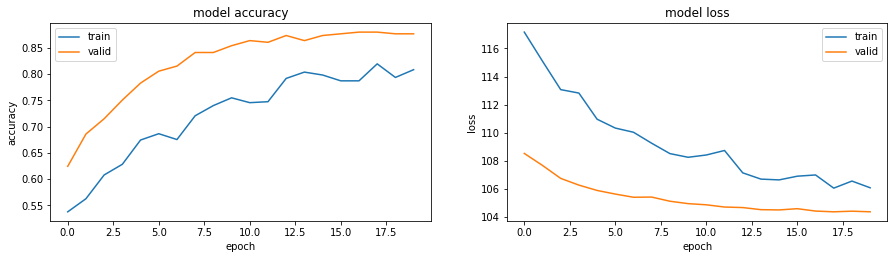


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-02 2.00e+00 5.00e-01 1.28e+02 1.00e+00]]
10/10 [==============================] - 0s 3ms/step - loss: 1.1961 - accuracy: 0.9579

Epoch 1: val_accuracy improved from -inf to 0.77023, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.77023 to 0.86084, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.86084 to 0.92233, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.92233

Epoch 5: val_accuracy improved from 0.92233 to 0.93204, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.93204 to 0.93528, saving model to VGG_16.h5

Epoch 7: val_accuracy did not improve from 0.93528

Epoch 8: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 8: val_accuracy did not improve from 0.93528

Epoch 9: val_accuracy did not improve from 0.93528
Epoch 9: early stopping
10/10 [==============================] - 0s 3ms/step - loss: 11.6828 - accuracy: 0.9353

LOSS:	11.682762145

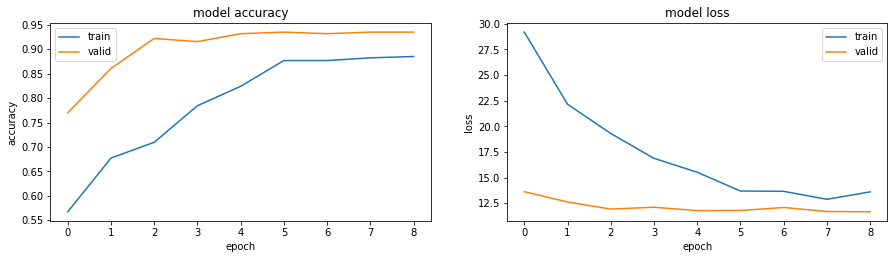


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-03 1.00e+00 3.00e-01 3.20e+01 3.00e+00]]
10/10 [==============================] - 0s 3ms/step - loss: 1.1961 - accuracy: 0.9579

Epoch 1: val_accuracy improved from -inf to 0.89644, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.89644 to 0.91909, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.91909 to 0.93851, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.93851 to 0.95146, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.95146

Epoch 6: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 6: val_accuracy did not improve from 0.95146

Epoch 7: val_accuracy did not improve from 0.95146
Epoch 7: early stopping
10/10 [==============================] - 0s 4ms/step - loss: 2.3722 - accuracy: 0.9450

LOSS:	2.3722190856933594 	 ACCURACY:	0.9449838399887085
[2.3722190856933594, 0.9449838399887085]



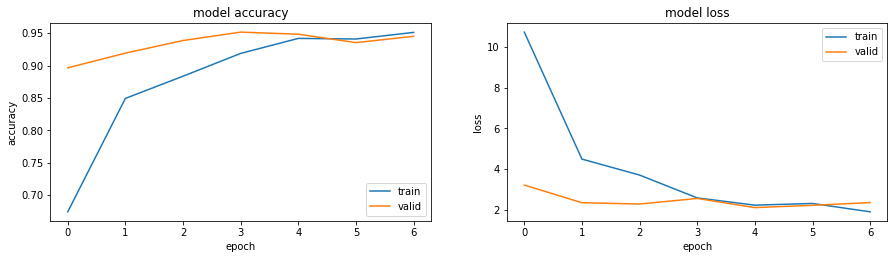


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-02 2.00e+00 5.00e-01 1.28e+02 1.00e+00]]
10/10 [==============================] - 0s 3ms/step - loss: 1.1961 - accuracy: 0.9579

Epoch 1: val_accuracy improved from -inf to 0.60194, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.60194 to 0.85761, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.85761 to 0.90615, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.90615 to 0.90939, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.90939 to 0.93204, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.93204 to 0.93528, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.93528 to 0.94175, saving model to VGG_16.h5

Epoch 8: val_accuracy did not improve from 0.94175

Epoch 9: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 9: val_accuracy did not improve from 0.94175

Epoch 10: val_accuracy did not improve from 0.94175
Epoch 10: early 

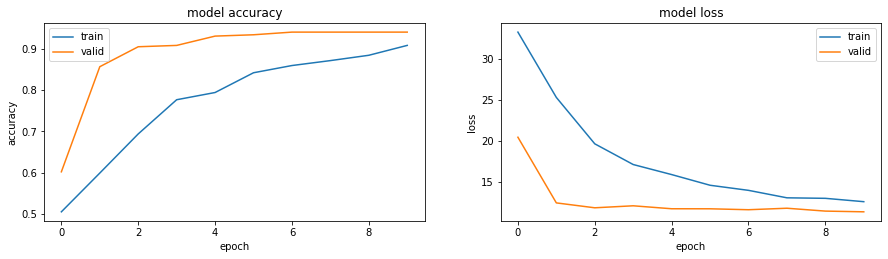


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-02 1.00e+00 3.00e-01 2.56e+02 1.00e+00]]
10/10 [==============================] - 0s 4ms/step - loss: 1.1961 - accuracy: 0.9579

Epoch 1: val_accuracy improved from -inf to 0.57282, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.57282 to 0.60518, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.60518 to 0.60841, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.60841 to 0.64078, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.64078 to 0.66019, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.66019 to 0.66343, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.66343 to 0.67314, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.67314 to 0.68932, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.68932 to 0.70874, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.70874 to 0.71521, saving model to VGG_16.h5


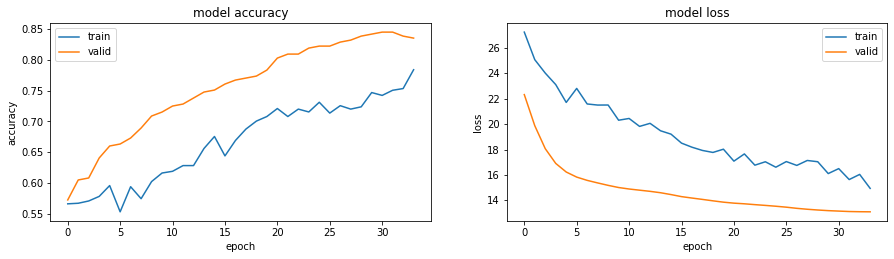


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-03 3.00e+00 5.00e-01 1.28e+02 3.00e+00]]
10/10 [==============================] - 0s 4ms/step - loss: 1.1961 - accuracy: 0.9579

Epoch 1: val_accuracy improved from -inf to 0.76052, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.76052 to 0.83819, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.83819 to 0.87702, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.87702 to 0.89644, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.89644 to 0.91586, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.91586 to 0.92233, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.92233 to 0.93204, saving model to VGG_16.h5

Epoch 8: val_accuracy did not improve from 0.93204

Epoch 9: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 9: val_accuracy did not improve from 0.93204

Epoch 10: val_accuracy did not improve from 0.93204
Epoch 10: early 

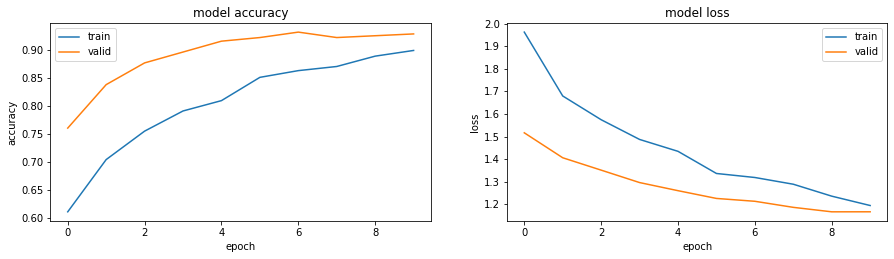


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-02 1.00e+00 3.00e-01 1.28e+02 2.00e+00]]
10/10 [==============================] - 0s 3ms/step - loss: 1.1961 - accuracy: 0.9579

Epoch 1: val_accuracy improved from -inf to 0.84790, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.84790 to 0.88997, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.88997 to 0.89644, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.89644 to 0.91909, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.91909

Epoch 6: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 6: val_accuracy did not improve from 0.91909

Epoch 7: val_accuracy improved from 0.91909 to 0.92880, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.92880 to 0.93528, saving model to VGG_16.h5

Epoch 9: val_accuracy did not improve from 0.93528

Epoch 10: ReduceLROnPlateau reducing learning rate to 3.599999909056351e-05.

Epoch 10: val_accurac

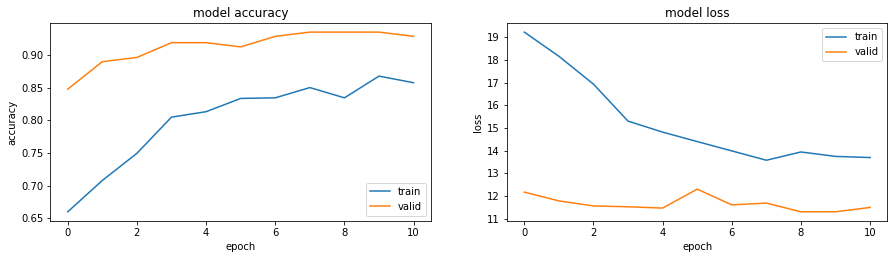


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-01 1.00e+00 7.00e-01 2.56e+02 3.00e+00]]
10/10 [==============================] - 0s 4ms/step - loss: 1.1961 - accuracy: 0.9579

Epoch 1: val_accuracy improved from -inf to 0.44013, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.44013 to 0.45631, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.45631 to 0.48220, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.48220 to 0.49838, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.49838 to 0.50809, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.50809 to 0.51456, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.51456 to 0.52427, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.52427 to 0.52751, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.52751 to 0.54045, saving model to VGG_16.h5

Epoch 10: val_accuracy did not improve from 0.54045

Epoch 11: val_accuracy improve

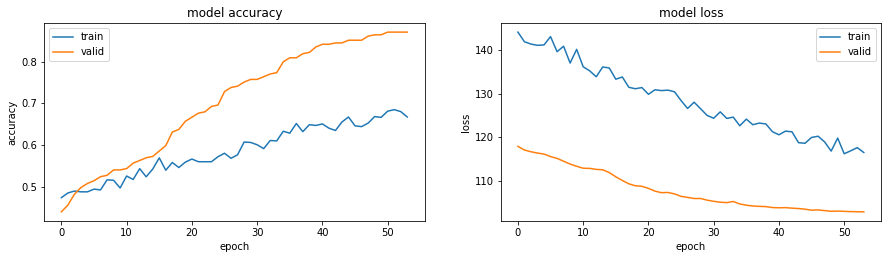


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-03 2.00e+00 3.00e-01 3.20e+01 1.00e+00]]
10/10 [==============================] - 0s 3ms/step - loss: 1.1961 - accuracy: 0.9579

Epoch 1: val_accuracy improved from -inf to 0.68608, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.68608 to 0.74757, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.74757 to 0.78964, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.78964 to 0.81877, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.81877 to 0.85113, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.85113 to 0.88026, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.88026 to 0.89320, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.89320 to 0.89644, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.89644 to 0.90291, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.90291 to 0.90939, saving model to VGG_16.h5


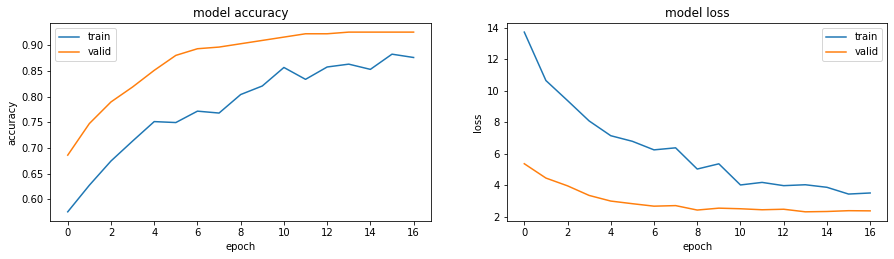


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-03 1.00e+00 5.00e-01 2.56e+02 3.00e+00]]
10/10 [==============================] - 0s 3ms/step - loss: 1.1961 - accuracy: 0.9579

Epoch 1: val_accuracy improved from -inf to 0.80259, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.80259

Epoch 3: val_accuracy improved from 0.80259 to 0.87055, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.87055

Epoch 5: val_accuracy improved from 0.87055 to 0.92880, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.92880 to 0.93204, saving model to VGG_16.h5

Epoch 7: val_accuracy did not improve from 0.93204

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 8: val_accuracy did not improve from 0.93204

Epoch 9: val_accuracy improved from 0.93204 to 0.94498, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.94498 to 0.94822, saving model to VGG_16.h5

Epoch 11: val_accuracy did not improve from 0.

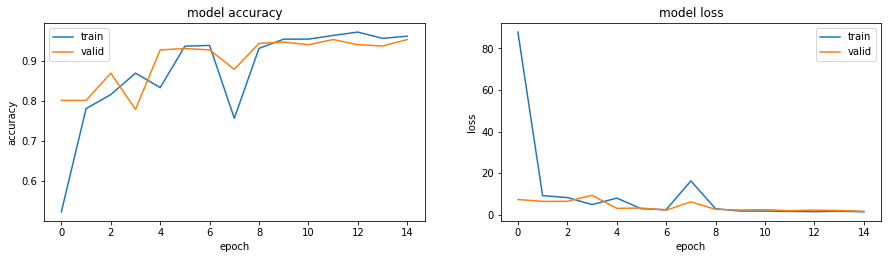


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-01 3.00e+00 5.00e-01 3.20e+01 2.00e+00]]
10/10 [==============================] - 0s 3ms/step - loss: 1.1961 - accuracy: 0.9579

Epoch 1: val_accuracy improved from -inf to 0.47896, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.47896

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.47896

Epoch 4: val_accuracy did not improve from 0.47896
Epoch 4: early stopping
10/10 [==============================] - 0s 4ms/step - loss: 104.3489 - accuracy: 0.4790

LOSS:	104.34889221191406 	 ACCURACY:	0.4789643883705139
[104.34889221191406, 0.4789643883705139]



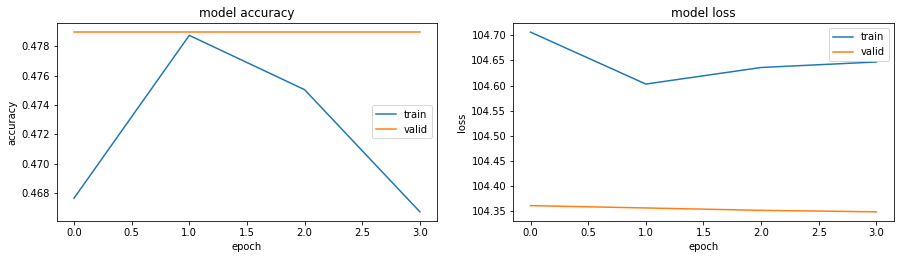


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-01 2.00e+00 5.00e-01 1.28e+02 2.00e+00]]
10/10 [==============================] - 0s 4ms/step - loss: 1.1961 - accuracy: 0.9579

Epoch 1: val_accuracy improved from -inf to 0.48220, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.48220

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.48220

Epoch 4: val_accuracy did not improve from 0.48220
Epoch 4: early stopping
10/10 [==============================] - 0s 3ms/step - loss: 114.3145 - accuracy: 0.4790

LOSS:	114.31452178955078 	 ACCURACY:	0.4789643883705139
[114.31452178955078, 0.4789643883705139]



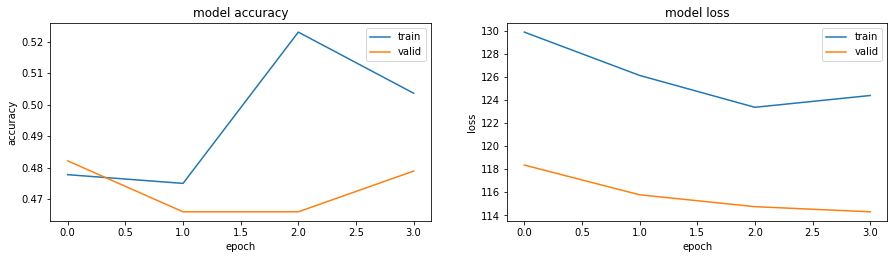


Hyperparameters: [[6.40e+01 1.00e-05 1.00e-01 2.00e+00 5.00e-01 2.56e+02 3.00e+00]]
10/10 [==============================] - 0s 3ms/step - loss: 1.1961 - accuracy: 0.9579

Epoch 1: val_accuracy improved from -inf to 0.57929, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.57929 to 0.58252, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.58252 to 0.59223, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.59223 to 0.59547, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.59547 to 0.61165, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.61165 to 0.61489, saving model to VGG_16.h5

Epoch 7: val_accuracy did not improve from 0.61489

Epoch 8: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 8: val_accuracy did not improve from 0.61489

Epoch 9: val_accuracy did not improve from 0.61489
Epoch 9: early stopping
10/10 [==============================] - 0s 3ms/step - loss: 18.9785 - accur

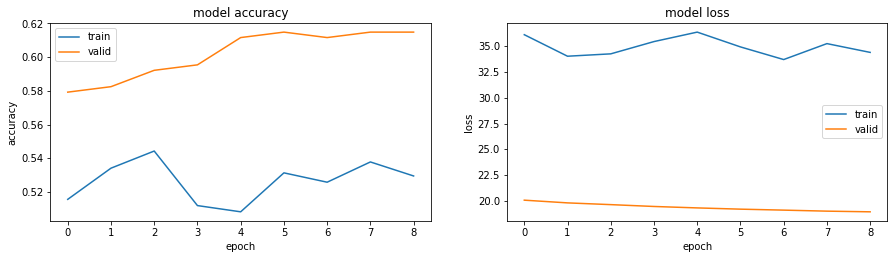


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-01 3.00e+00 5.00e-01 3.20e+01 3.00e+00]]
10/10 [==============================] - 0s 5ms/step - loss: 1.1961 - accuracy: 0.9579

Epoch 1: val_accuracy improved from -inf to 0.53074, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.53074 to 0.57282, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.57282 to 0.58252, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.58252 to 0.59871, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.59871 to 0.64725, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.64725 to 0.67961, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.67961 to 0.69903, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.69903 to 0.72492, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.72492 to 0.72816, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.72816 to 0.75081, saving model to VGG_16.h5


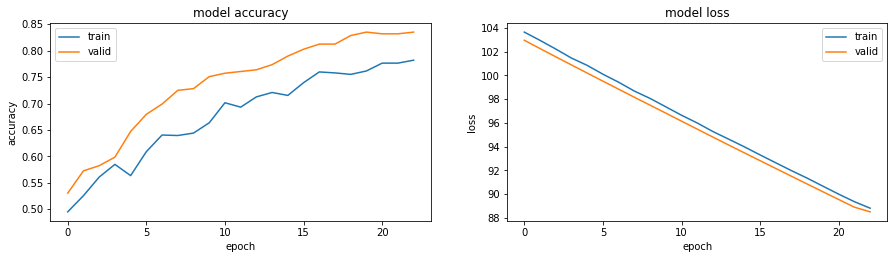


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-03 1.00e+00 7.00e-01 1.28e+02 2.00e+00]]
10/10 [==============================] - 0s 4ms/step - loss: 1.1961 - accuracy: 0.9579

Epoch 1: val_accuracy improved from -inf to 0.59871, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.59871 to 0.63430, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.63430 to 0.66343, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.66343 to 0.70227, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.70227 to 0.73786, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.73786 to 0.76052, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.76052 to 0.76699, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.76699 to 0.77994, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.77994 to 0.78964, saving model to VGG_16.h5

Epoch 10: val_accuracy did not improve from 0.78964

Epoch 11: val_accuracy improve

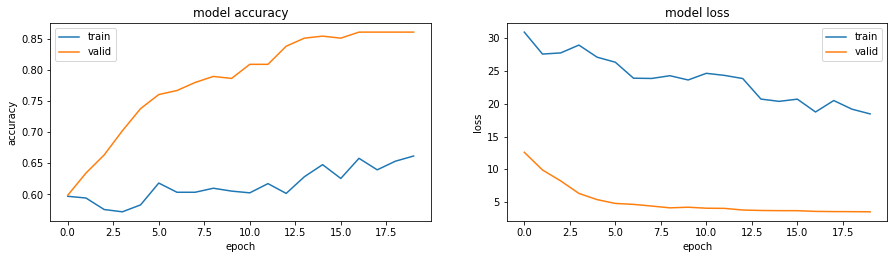


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-03 2.00e+00 5.00e-01 2.56e+02 1.00e+00]]
10/10 [==============================] - 0s 4ms/step - loss: 1.1961 - accuracy: 0.9579

Epoch 1: val_accuracy improved from -inf to 0.56958, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.56958

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.56958

Epoch 4: val_accuracy did not improve from 0.56958
Epoch 4: early stopping
10/10 [==============================] - 0s 3ms/step - loss: 28.8996 - accuracy: 0.5663

LOSS:	28.89963150024414 	 ACCURACY:	0.5663430690765381
[28.89963150024414, 0.5663430690765381]



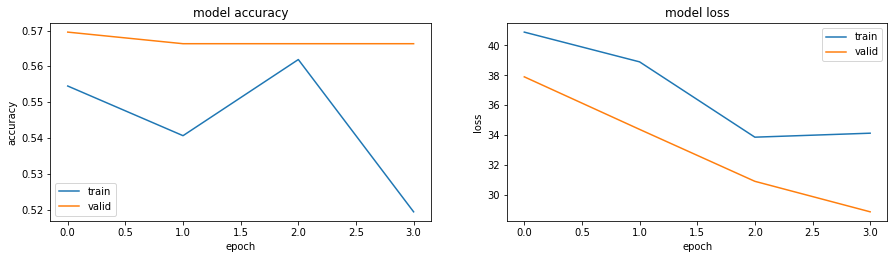


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-01 3.00e+00 3.00e-01 1.28e+02 1.00e+00]]
10/10 [==============================] - 0s 4ms/step - loss: 1.1961 - accuracy: 0.9579

Epoch 1: val_accuracy improved from -inf to 0.46278, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.46278

Epoch 3: val_accuracy improved from 0.46278 to 0.46602, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.46602

Epoch 5: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 5: val_accuracy did not improve from 0.46602

Epoch 6: val_accuracy did not improve from 0.46602
Epoch 6: early stopping
10/10 [==============================] - 0s 4ms/step - loss: 103.7824 - accuracy: 0.4660

LOSS:	103.78237915039062 	 ACCURACY:	0.4660194218158722
[103.78237915039062, 0.4660194218158722]



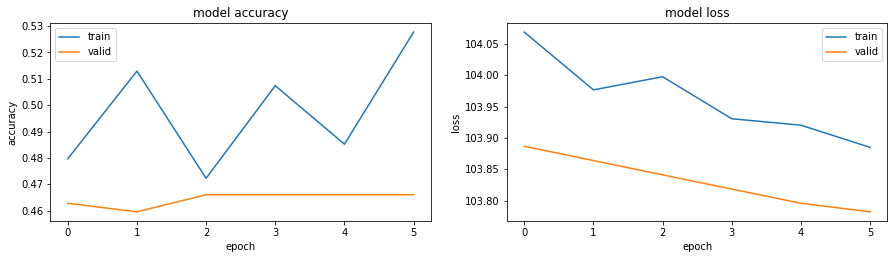


Hyperparameters: [[6.4e+01 1.0e-04 1.0e-01 3.0e+00 3.0e-01 3.2e+01 2.0e+00]]
10/10 [==============================] - 0s 3ms/step - loss: 1.1961 - accuracy: 0.9579

Epoch 1: val_accuracy improved from -inf to 0.47896, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.47896 to 0.50809, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.50809 to 0.51456, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.51456 to 0.51780, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.51780 to 0.53398, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.53398 to 0.55987, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.55987 to 0.57282, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.57282 to 0.60518, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.60518 to 0.63754, saving model to VGG_16.h5

Epoch 10: val_accuracy did not improve from 0.63754

Epoch 11: val_accuracy improved from 

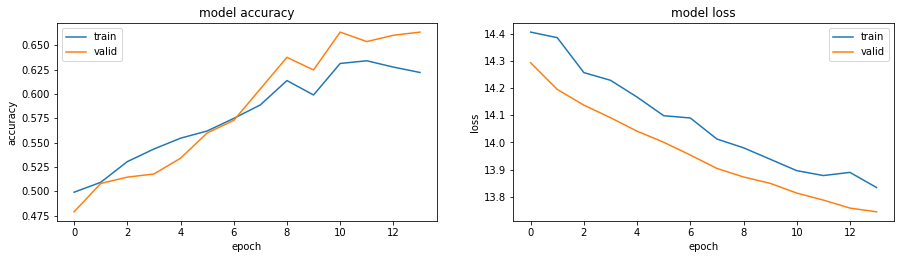


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-03 1.00e+00 5.00e-01 2.56e+02 1.00e+00]]
10/10 [==============================] - 0s 3ms/step - loss: 1.1961 - accuracy: 0.9579

Epoch 1: val_accuracy improved from -inf to 0.41100, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.41100 to 0.45307, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.45307 to 0.46926, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.46926 to 0.47573, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.47573 to 0.47896, saving model to VGG_16.h5

Epoch 6: val_accuracy did not improve from 0.47896

Epoch 7: val_accuracy improved from 0.47896 to 0.48544, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.48544 to 0.49191, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.49191 to 0.49515, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.49515 to 0.51133, saving model to VGG_16.h5

Epoch 11: val_accuracy improve

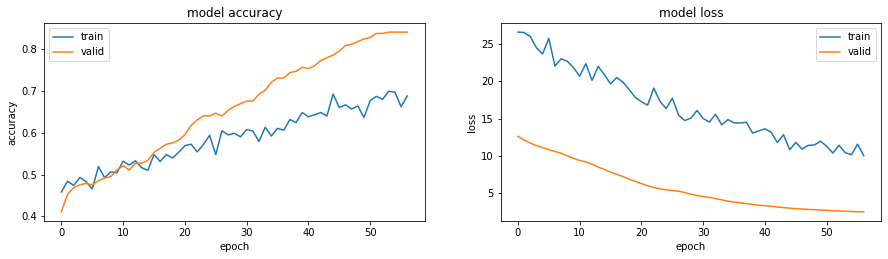


Hyperparameters: [[2.56e+02 1.00e-03 1.00e-03 3.00e+00 3.00e-01 2.56e+02 3.00e+00]]
10/10 [==============================] - 0s 4ms/step - loss: 1.1961 - accuracy: 0.9579

Epoch 1: val_accuracy improved from -inf to 0.89644, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.89644

Epoch 3: val_accuracy improved from 0.89644 to 0.92880, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.92880

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 5: val_accuracy did not improve from 0.92880

Epoch 6: val_accuracy improved from 0.92880 to 0.93204, saving model to VGG_16.h5

Epoch 7: val_accuracy did not improve from 0.93204

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 8: val_accuracy did not improve from 0.93204

Epoch 9: val_accuracy improved from 0.93204 to 0.93851, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.93851 to 0.94822, saving model to VGG_16.h5



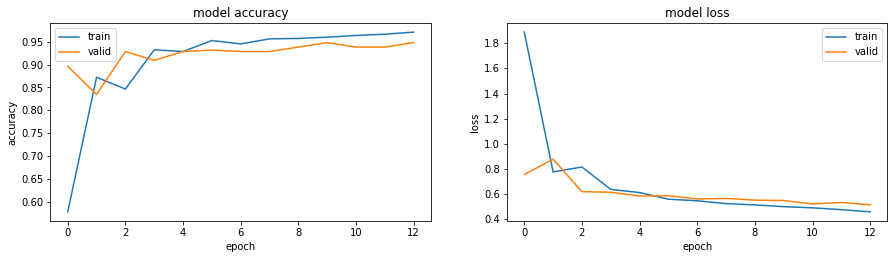


Hyperparameters: [[2.56e+02 1.00e-03 1.00e-01 2.00e+00 5.00e-01 3.20e+01 1.00e+00]]
10/10 [==============================] - 0s 3ms/step - loss: 1.1961 - accuracy: 0.9579

Epoch 1: val_accuracy improved from -inf to 0.94822, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.94822 to 0.95146, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.95146

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 4: val_accuracy did not improve from 0.95146

Epoch 5: val_accuracy improved from 0.95146 to 0.95793, saving model to VGG_16.h5

Epoch 6: val_accuracy did not improve from 0.95793

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 7: val_accuracy did not improve from 0.95793

Epoch 8: val_accuracy did not improve from 0.95793
Epoch 8: early stopping
10/10 [==============================] - 0s 5ms/step - loss: 15.1620 - accuracy: 0.9515

LOSS:	15.16198444366455 	 ACCURACY:	0.9514563083648682


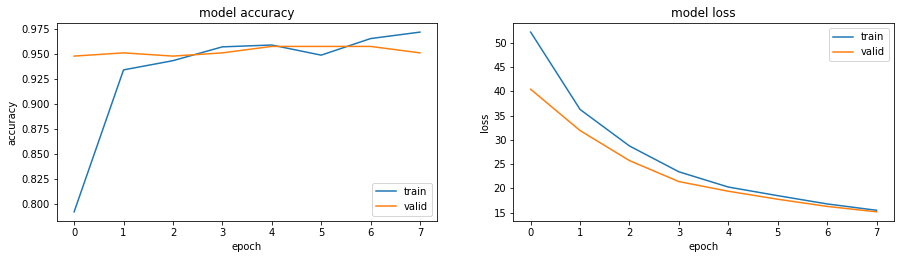


Hyperparameters: [[2.56e+02 1.00e-04 1.00e-02 2.00e+00 3.00e-01 1.28e+02 1.00e+00]]
10/10 [==============================] - 0s 4ms/step - loss: 1.1961 - accuracy: 0.9579

Epoch 1: val_accuracy improved from -inf to 0.55663, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.55663 to 0.68932, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.68932 to 0.74434, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.74434 to 0.81877, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.81877 to 0.85113, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.85113 to 0.86408, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.86408 to 0.88997, saving model to VGG_16.h5

Epoch 8: val_accuracy did not improve from 0.88997

Epoch 9: val_accuracy improved from 0.88997 to 0.90291, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.90291 to 0.90615, saving model to VGG_16.h5

Epoch 11: val_accuracy improve

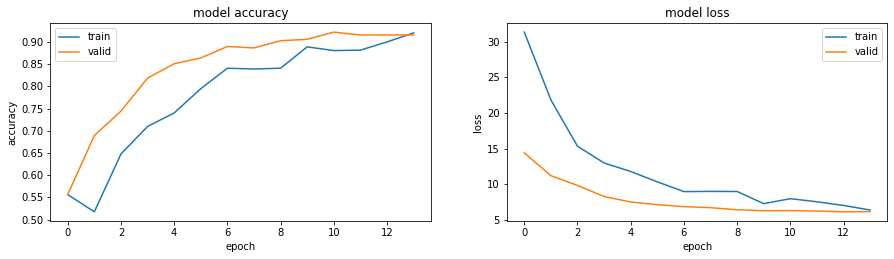


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-03 1.00e+00 5.00e-01 3.20e+01 1.00e+00]]
10/10 [==============================] - 0s 4ms/step - loss: 1.1961 - accuracy: 0.9579

Epoch 1: val_accuracy improved from -inf to 0.59223, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.59223 to 0.66019, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.66019 to 0.70227, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.70227 to 0.73139, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.73139 to 0.76375, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.76375 to 0.79612, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.79612 to 0.80583, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.80583 to 0.83495, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.83495 to 0.84466, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.84466 to 0.84790, saving model to VGG_16.h5


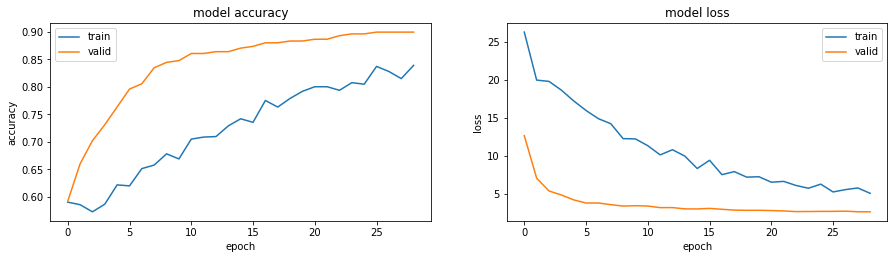


Hyperparameters: [[2.56e+02 1.00e-03 1.00e-03 1.00e+00 3.00e-01 3.20e+01 2.00e+00]]
10/10 [==============================] - 0s 4ms/step - loss: 1.1961 - accuracy: 0.9579

Epoch 1: val_accuracy improved from -inf to 0.92233, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.92233

Epoch 3: val_accuracy improved from 0.92233 to 0.94822, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.94822

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 5: val_accuracy did not improve from 0.94822

Epoch 6: val_accuracy did not improve from 0.94822
Epoch 6: early stopping
10/10 [==============================] - 0s 3ms/step - loss: 0.8955 - accuracy: 0.9417

LOSS:	0.8955004215240479 	 ACCURACY:	0.9417475461959839
[0.8955004215240479, 0.9417475461959839]



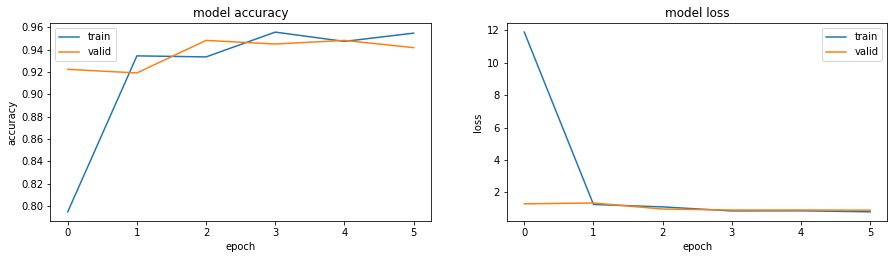


Hyperparameters: [[2.56e+02 1.00e-04 1.00e-03 1.00e+00 7.00e-01 3.20e+01 3.00e+00]]
10/10 [==============================] - 0s 5ms/step - loss: 1.1961 - accuracy: 0.9579

Epoch 1: val_accuracy improved from -inf to 0.81230, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.81230 to 0.86084, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.86084 to 0.92880, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.92880 to 0.93204, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.93204

Epoch 6: val_accuracy improved from 0.93204 to 0.94498, saving model to VGG_16.h5

Epoch 7: val_accuracy did not improve from 0.94498

Epoch 8: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 8: val_accuracy did not improve from 0.94498

Epoch 9: val_accuracy did not improve from 0.94498
Epoch 9: early stopping
10/10 [==============================] - 0s 3ms/step - loss: 1.7807 - accuracy: 0.9417

LOSS:	1.78071475028

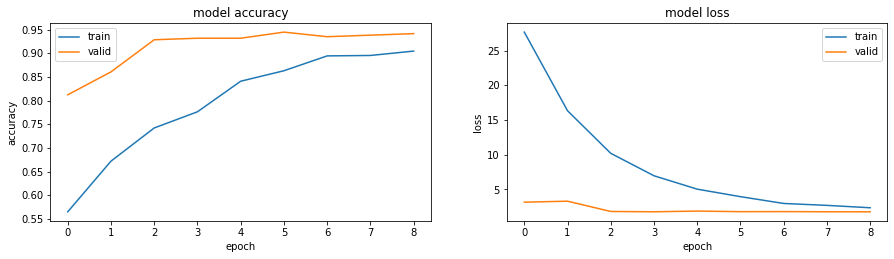


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-03 3.00e+00 3.00e-01 1.28e+02 3.00e+00]]
10/10 [==============================] - 0s 4ms/step - loss: 1.1961 - accuracy: 0.9579

Epoch 1: val_accuracy improved from -inf to 0.46602, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.46602 to 0.48867, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.48867 to 0.51456, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.51456 to 0.53398, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.53398 to 0.54693, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.54693 to 0.56634, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.56634 to 0.57605, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.57605 to 0.58252, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.58252 to 0.59547, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.59547 to 0.61165, saving model to VGG_16.h5


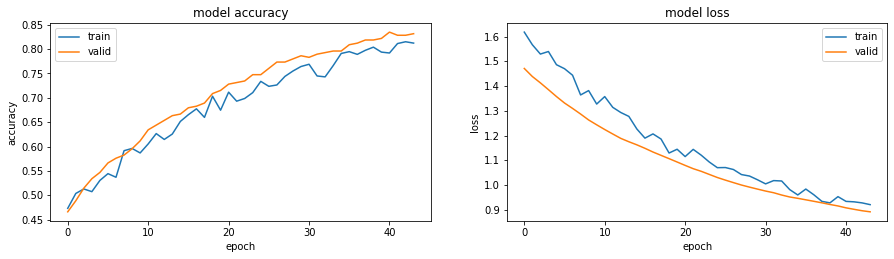


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-01 2.00e+00 5.00e-01 3.20e+01 1.00e+00]]
10/10 [==============================] - 0s 4ms/step - loss: 1.1961 - accuracy: 0.9579

Epoch 1: val_accuracy improved from -inf to 0.57605, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.57605 to 0.59223, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.59223 to 0.62136, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.62136 to 0.65372, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.65372 to 0.69579, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.69579 to 0.72816, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.72816 to 0.76699, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.76699 to 0.77023, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.77023 to 0.78964, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.78964 to 0.79288, saving model to VGG_16.h5


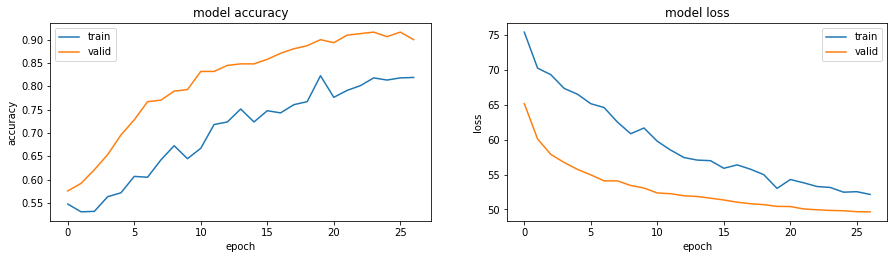


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-01 2.00e+00 5.00e-01 3.20e+01 1.00e+00]]
10/10 [==============================] - 0s 4ms/step - loss: 1.1961 - accuracy: 0.9579

Epoch 1: val_accuracy improved from -inf to 0.50162, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.50162 to 0.55987, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.55987 to 0.60194, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.60194 to 0.63107, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.63107 to 0.68608, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.68608 to 0.73463, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.73463 to 0.77023, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.77023 to 0.81553, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.81553 to 0.83495, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.83495 to 0.86408, saving model to VGG_16.h5


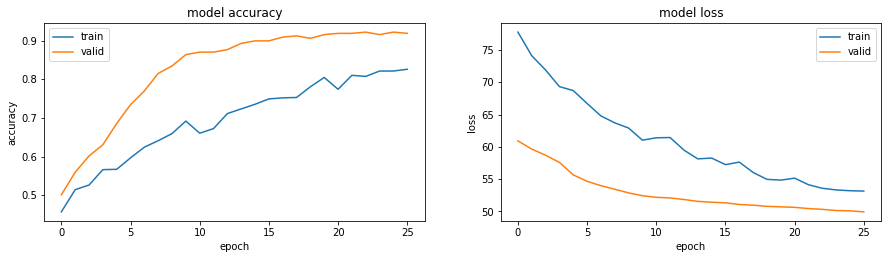

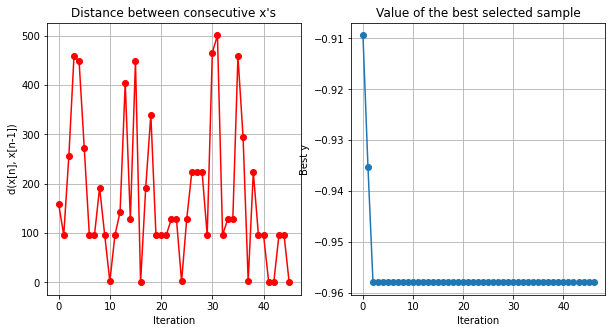

In [ ]:
# define the kernel for the Bayesian surrogate model using the "radial basis function" (RBF)
kernel = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=1.0)
# hyperparameter bounds
bounds = [{'name': 'units', 'type': 'discrete', 'domain': (64, 128, 256, 512)},
          {'name': 'learning_rate', 'type': 'discrete', 'domain': (1e-3, 1e-4, 1e-5, 1e-6)},
          {'name': 'l2', 'type': 'discrete', 'domain': (1e-1, 1e-2, 1e-3)},
          {'name': 'activation', 'type': 'discrete', 'domain': (1, 2, 3)},
          {'name': 'rate', 'type': 'discrete', 'domain': (0.3, 0.5, 0.7)},
          {'name': 'batch', 'type': 'discrete', 'domain': (32, 128, 256)},
          {'name': 'optim', 'type': 'discrete', 'domain': (1, 2, 3)}]
# Note: 'activation' domain parameters (1, 2, 3) correspond to strings ('relu', 'elu', 'tanh'); dictionary defined in build_model()
# Note: 'optim' domain parameters (1, 2, 3) correspond to strings ('Adam', 'SGD', 'RMSprop'); dictionary defined in build_model()
# objective function for the model optimization:
def f(x):
  """objective function of the Bayesian surrogate model"""
  print()
  print("Hyperparameters:", x)
  # Retrieve 'accuracy' from the previously saved model
  try:
    previous_best_model = K.models.load_model('VGG_16_best.h5')
    previous_evaluation = evaluate_model(previous_best_model)
  except Exception:
    previous_best_model = None
  model, lr_reduce, early_stop, checkpoint, batch = build_model(
                                        units=int(x[:,0]),
                                        learning_rate=float(x[:,1]),
                                        l2=float(x[:,2]),
                                        activation=int(x[:,3]),
                                        rate=float(x[:,4]),
                                        batch=int(x[:,5]),
                                        optim=int(x[:,6]))
  history = fit_model(model, lr_reduce, early_stop, checkpoint, batch)
  evaluation = evaluate_model(model)
  print()
  print("LOSS:\t{0} \t ACCURACY:\t{1}".format(evaluation[0],evaluation[1]))
  #print("LOSS:\t{0} \t ACCURACY:\t{1} \t PRECISION:\t{2} \t RECALL:\t{3} \t F1-SCORE:\t{4}".format(evaluation[0], evaluation[1], evaluation[2], evaluation[3], evaluation[4]))
  print(evaluation)
  print()
  # compare previous and current validation accuracies
  if not previous_best_model:
    K.models.save_model(model, 'VGG_16_best.h5', overwrite=True,
    include_optimizer=True)
  if previous_best_model and evaluation[1] > previous_evaluation[1]:
    K.models.save_model(model, 'VGG_16_best.h5', overwrite=True,
    include_optimizer=True)
  # Get the dictionary containing each metric and the loss for each epoch
  # history_dict = history.history
  # print(history_dict)
  def plot_history(history):
  #function that plots the model loss and accuracy
    plt.figure(1, figsize = (15,8))
    plt.subplot(221)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'])
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'])
    plt.show()
  # plot the model accuracy and loss results
  plot_history(history)
  # delete the instantiated models from memory and clear the session
  del model
  del previous_best_model
  K.backend.clear_session()
  return evaluation[1]
# Initializing X and Y, and adding noise (if need be)
# X_init = np.array([[int(16)]])
# Y_init = f(X_init)
# noise = 0.2
optimizer = BayesianOptimization(f=f,
                                 domain=bounds,
                                 model_type='GP',
                                 kernel=kernel,
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.01,
                                 # X=X_init,
                                 # Y=-Y_init,
                                 # noise_var = noise**2,
                                 exact_feval=False,
                                 normalize_Y=False,
                                 maximize=True,
                                 verbosity=False)
print()
print("=====================")
print("=====================")
print()
optimizer.run_optimization(max_iter=100, verbosity=False)
optimizer.plot_acquisition()
optimizer.plot_convergence()
optimizer.save_report('bayes_opt.txt')

In [ ]:
# print optimized model
activation_dict = {1: 'relu', 2: 'elu', 3: 'tanh'}
optimizer_dict = {1: 'Adam', 2: 'SGD', 3: 'RMSprop'}
print("""
Optimized Parameters:
\t{0}:\t{1}
\t{2}:\t{3}
\t{4}:\t{5}
\t{6}:\t{7}
\t{8}:\t{9}
\t{10}:\t{11}
""".format(bounds[0]["name"], optimizer.x_opt[0],
           bounds[1]["name"], optimizer.x_opt[1],
           bounds[2]["name"], optimizer.x_opt[2],
           bounds[3]["name"], activation_dict[optimizer.x_opt[3]],
           bounds[4]["name"], optimizer.x_opt[4],
           bounds[5]["name"], optimizer.x_opt[5]),
           bounds[6]["name"], optimizer_dict[optimizer.x_opt[6]])
print("optimized accuracy: {0}".format(abs(optimizer.fx_opt)))


Optimized Parameters:
	units:	256.0
	learning_rate:	0.001
	l2:	0.001
	activation:	elu
	rate:	0.5
	batch:	128.0
 optim Adam
optimized accuracy: [0.95792878]


In [ ]:
# reinstantiate the best model from saved file
best_model = K.models.load_model('VGG_16_best.h5')
best_model.summary()
loss, acc = best_model.evaluate(features_valid, y_test) 
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512)]             0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 131,842
Trainable params: 131,842
Non-trainable params: 0
_________________________________________________________________
10/10 [==============================] - 0s 3ms/step - loss: 1.1961 - accuracy: 0.9579
Restored model, accuracy: 95.79%


In [ ]:
best_model.evaluate(features_valid, y_test)

10/10 [==============================] - 0s 2ms/step - loss: 1.1961 - accuracy: 0.9579


[1.1960623264312744, 0.9579287767410278]

In [ ]:
data_path = 'bayes_opt.txt'
with open(data_path, 'r') as f:
  lines = f.read().split('\n')
for line in lines:
  print(line)

----------------------------- GPyOpt Report file -----------------------------------
GPyOpt Version 1.2.1
Date and time:               Thu Jan  5 15:26:24 2023
Optimization completed:      NO,47 samples collected.
Number initial samples:      5 
Tolerance:                   1e-08.
Optimization time:           153.66269159317017 seconds.

-------------------------------- Problem set up ------------------------------------
Problem name:                no_name
Problem dimension:           7
Number continuous variables  0
Number discrete variables    7
Number bandits               0
Noiseless evaluations:       False
Cost used:                   Used defined cost
Constrains:                  False

------------------------------ Optimization set up ---------------------------------
Normalized outputs:          False
Model type:                  GP
Model update interval:       1
Acquisition type:            EI
Acquisition optimizer:       lbfgs
Acquisition type:            EI
Acquisition op

Test model with test data

In [ ]:
#https://stackoverflow.com/questions/55674648/how-to-load-local-dataset-x-y-using-keras-framework
!pip install image-dataset-loader
from image_dataset_loader import load

(x_train, y_train), (x_test, y_test) = load('/content/output/', ['train', 'test'])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#  preprocess the data using the application's preprocess_input method and convert the labels to one-hot encodings
x_test, y_test = preprocess_data(x_test, y_test)

In [ ]:

# repeat the same operation with the test data (here used for test)
test_datagen = K.preprocessing.image.ImageDataGenerator()  # no augmentation for test set
test_generator = test_datagen.flow(x_test,
                                 y_test,
                                 batch_size=32,
                                 shuffle=False)
features_test = base_model.predict(test_generator)

5/5 [==============================] - 3s 747ms/step


In [ ]:
# reinstantiate the best model from saved file
loss, acc = best_model.evaluate(features_test, y_test) 
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

5/5 [==============================] - 0s 3ms/step - loss: 1.4203 - accuracy: 0.9359
Restored model, accuracy: 93.59%


In [ ]:
best_model.evaluate(features_test, y_test)

5/5 [==============================] - 0s 3ms/step - loss: 1.4203 - accuracy: 0.9359


[1.4203391075134277, 0.9358974099159241]